In [1]:
#LOADING LIBRARIES
%matplotlib inline
#%pylab inline

import pandas as pd
#import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
#import pylab
import sklearn
import time
import gc
import re

from sklearn import cross_validation, metrics, neighbors
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.grid_search import GridSearchCV
from scipy.stats import gaussian_kde
from sklearn.svm import SVC, NuSVC, LinearSVC, SVR, NuSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA, RandomizedPCA, TruncatedSVD
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.datasets import load_svmlight_file
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
#from xgboost.sklearn import XGBClassifier
from scipy import sparse
from multiprocessing import Pool


gc.enable()
np.random.seed(455)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)




In [2]:
#LOADING AND JOINING THE DATA

import os
import glob
#print (glob.glob("../kaggle_data/*.csv"))

df_train = pd.read_csv('../kaggle_data/train_users_2.csv')
df_test = pd.read_csv('../kaggle_data/test_users.csv')
labels = df_train['country_destination'].values


id_test = df_test['id']
count_rows_train = df_train.shape[0]
count_rows_test = df_test.shape[0]
print ("Total users in train: ",count_rows_train)
print ("Total users in test: ",count_rows_test)

df_test['country_destination'] = -1

#Creating a DataFrame with train+test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)
#Filling nan
df_all = df_all.fillna(-1)

del df_test, df_train



Total users in train:  213451
Total users in test:  62096


16.0


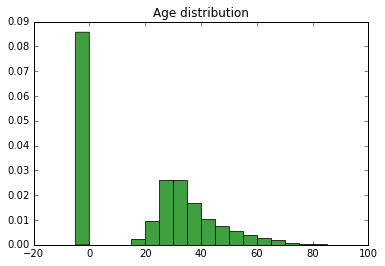

16.0


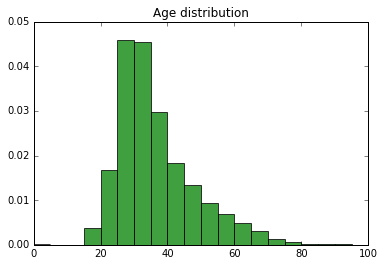

In [3]:
## Building age graphs

## Graph 1
plt_data = np.copy(df_all.age [df_all.age<100])

n_bins = np.arange(-5,100,5)

print (min(plt_data[plt_data>15]))
n, bins, patches = plt.hist(plt_data,bins = n_bins, normed=1, facecolor='green', alpha=0.75)
plt.title ("Age distribution")
plt.show ()


## Graph 2
plt_data = np.copy(df_all.age [df_all.age<100])

n_bins = np.arange(0,100,5)

print (min(plt_data[plt_data>15]))
n, bins, patches = plt.hist(plt_data,bins = n_bins, normed=1, facecolor='green', alpha=0.75)
plt.title ("Age distribution")
plt.show ()

In [4]:
#####Feature engineering#######

#date_account_created
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]


#timestamp_first_active
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]

#Age
av = np.copy(df_all.age.values)
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)
 

#Removing columns that won't be included into model

df_all = df_all.drop(['id', 'date_first_booking','country_destination','date_account_created',
                     'timestamp_first_active',], axis=1)

#print ("\nVar names:\n",df_all.columns.values)
print ("new columns created")


new columns created


In [5]:
## loading 'summary statistics of users' age group, gender, country of destination'

age_gender_bkts = pd.read_csv('../kaggle_data/age_gender_bkts.csv')

## removing irrelevant ages
age_filter = np.any([age_gender_bkts.age_bucket == '100+', age_gender_bkts.age_bucket == '0-4',
             age_gender_bkts.age_bucket == '5-9', age_gender_bkts.age_bucket == '10-14'], axis=0)




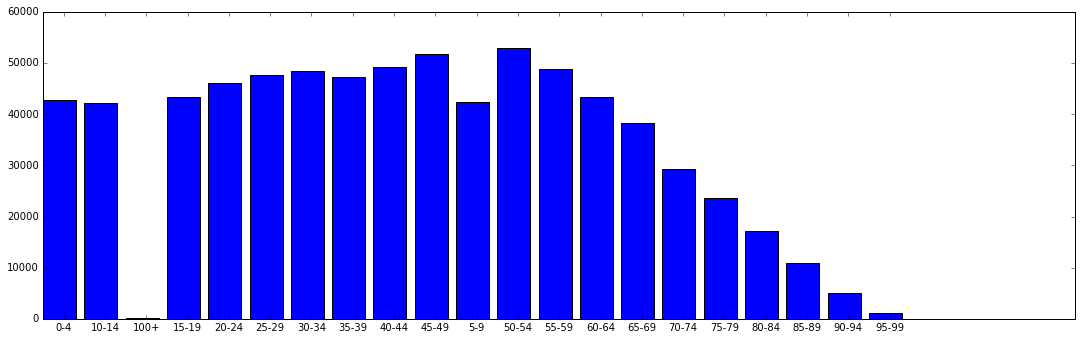

In [6]:
tt_data = age_gender_bkts[['age_bucket','population_in_thousands']].groupby(['age_bucket']).sum()

ind = np.arange(tt_data.shape[0])

fig = plt.gcf()
fig.set_size_inches(18.5, 5.5)
plt.bar(ind, tt_data.values)
plt.xticks(ind+0.5, tt_data.index)
plt.show()




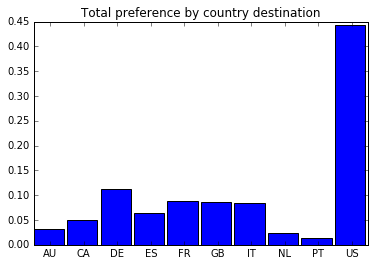

In [7]:
## sum of all visits by country_destination and percentage

dfsum_by_country = age_gender_bkts.groupby(['country_destination','year'], as_index=False).sum()
dfsum_by_country = dfsum_by_country[["country_destination","population_in_thousands"]]
dfsum_by_country = dfsum_by_country.rename(columns = {"population_in_thousands": "sum_by_dest"})
dfsum_by_country['prob_dest'] = dfsum_by_country.sum_by_dest/ sum( dfsum_by_country.sum_by_dest)
#print (dfsum_by_country[['country_destination','prob_dest']])

ind = np.arange(10)
width = 0.9
plt.bar(ind, dfsum_by_country['prob_dest'],width)
plt.xticks(ind + 0.5,dfsum_by_country['country_destination'])
plt.title ("Total preference by country destination")
plt.show()

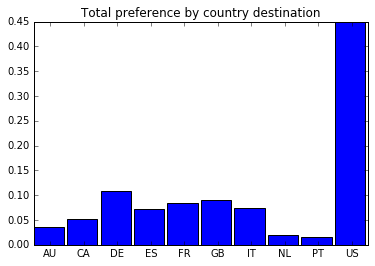

In [33]:
## sum of visits by age gender

dfsum_by_age_gender = age_gender_bkts.groupby(['age_bucket','gender','year'], as_index=False).sum()
dfsum_by_age_gender = dfsum_by_age_gender[["age_bucket","gender","population_in_thousands"]]
dfsum_by_age_gender = dfsum_by_age_gender.rename(columns = {"population_in_thousands": "sum_by_age_gender"})
dfsum_by_age_gender = pd.merge (age_gender_bkts,dfsum_by_age_gender, on = ["age_bucket","gender"], how = "left")
dfsum_by_age_gender['prob_age_gender'] = dfsum_by_age_gender['population_in_thousands']/dfsum_by_age_gender['sum_by_age_gender']
##print (dfsum_by_age_gender)


gr_filter = np.all([dfsum_by_age_gender['gender']=='male', dfsum_by_age_gender['age_bucket']=='30-34'], axis=0)
dd = dfsum_by_age_gender[gr_filter]
##print (dd)

ind = np.arange(dd.shape[0])
width = 0.9
plt.bar(ind, dd['prob_age_gender'],width)
plt.xticks(ind + 0.5,dfsum_by_country['country_destination'])
plt.title ("Total preference by country destination")
plt.show()



In [31]:
## linking country destination and other available data

def get_age_group(x):
    age_group = round(x // 5,0)
    age_group =  "%.0f" % (age_group * 5)+ "-"+"%.0f" % (age_group*5+4)
    
    if x == -1:
        age_group = -1
    return age_group

def get_gender(x):
    gender = "female"
    if x == 1:
        gender == "male"
    if x == -1:          ## gender unknown
        gender = -1
    return gender

df_link = df_all[['age','gender_MALE']].copy()

df_link.loc[:,'gender_MALE'] = df_link.loc[:,'gender_MALE'] - df_all.loc[:,'gender_-unknown-']


df_link.loc[:,'age_group'] = list(map (lambda x: get_age_group(x), df_link.age))
df_link.loc[:,'gender_group'] = list(map (lambda x: get_gender(x), df_link.gender_MALE))

## my_filt = np.all([df_link.gender_group!=-1, df_link.age_group!=-1],axis=0)

## print (df_link.shape[0])
## print (sum(my_filt))
df_link.head()


,age,gender_MALE,age_group,gender_group
0,-1,-1,-1,-1
1,38,1,35-39,female
2,56,0,55-59,female
3,42,0,40-44,female
4,41,-1,40-44,-1


,country_destination,sum_by_dest,prob_dest
0,AU,23923,0.032677
1,CA,35871,0.048996
2,DE,82562,0.112772
3,ES,47203,0.064475
4,FR,64983,0.088761
5,GB,63840,0.087199
6,IT,61145,0.083518
7,NL,16848,0.023013
8,PT,10609,0.014491
9,US,325132,0.444099


In [78]:
def get_all_countries (x):
    print (x)
    str_dat = x  #df_link.loc[1,:]
    dat = dfsum_by_age_gender[np.all([dfsum_by_age_gender.age_bucket==str_dat.age_group, dfsum_by_age_gender.gender==str_dat.gender_group],axis=0)]
    dat = dat.sort_values(by = 'country_destination')
    res = dat.prob_age_gender.values
    if len(res) == 0:
        dat = dfsum_by_country.sort_values(by = 'country_destination')
        res =dat.prob_dest.values
        
    print (res)
    return (res)
    
    
#get_all_countries (df_link.loc[1,:])
df_link.range

df_link.loc[1:8,:].apply(get_all_countries, axis=1) # equiv to df.sum(0)

age                 38
gender_MALE          1
age_group        35-39
gender_group    female
Name: 1, dtype: object
[ 0.03404599  0.05066519  0.10209546  0.08356357  0.07888809  0.08347856
  0.08883411  0.02082713  0.0175968   0.4400051 ]
age                 38
gender_MALE          1
age_group        35-39
gender_group    female
Name: 1, dtype: object
[ 0.03404599  0.05066519  0.10209546  0.08356357  0.07888809  0.08347856
  0.08883411  0.02082713  0.0175968   0.4400051 ]
age                 56
gender_MALE          0
age_group        55-59
gender_group    female
Name: 2, dtype: object
[ 0.02960026  0.05227109  0.1200032   0.0613234   0.08511576  0.07974846
  0.08287271  0.02323159  0.01465994  0.4511736 ]
age                 42
gender_MALE          0
age_group        40-44
gender_group    female
Name: 3, dtype: object
[ 0.03408167  0.04754352  0.10407516  0.07824955  0.09073532  0.08731902
  0.09805596  0.02371075  0.01700016  0.41922889]
age                41
gender_MALE        -1
age_

ValueError: Shape of passed values is (8, 10), indices imply (8, 4)

In [191]:
# Splitting data back into test and train samples
vals = df_all.values
X = vals[:count_rows_train]
le = LabelEncoder()
y = le.fit_transform(labels)   


X_test = vals[count_rows_train:]

print(labels)
print (y)

['NDF' 'NDF' 'US' ..., 'NDF' 'NDF' 'NDF']
[ 7  7 10 ...,  7  7  7]


In [8]:
# Selecting training data
X_train, X_test, y_train, y_test = train_test_split (X,y,train_size=0.1, random_state=222)
print (X_train.shape)

(21345, 161)


In [ ]:

#Classifier
# 40 minutes - full run
# preprocess
# 4 minutes
import time

print ("fitting the mode")
start_time = time.time()

xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(X_train, y_train)
elapsed_time = round((time.time() - start_time)/60,2)

print (elapsed_time)

